In [22]:
# !pip install timm # Installing timm, a computer vision library for pytorch
# # Downloading a swin IR Model.
# # More models can be found here: https://github.com/JingyunLiang/SwinIR/releases/
# # !wget -O swin-ir.pth https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/001_classicalSR_DF2K_s64w8_SwinIR-M_x2.pth # these weights.

In [46]:
import torch
from torch import nn
from torch.nn import functional as F
import timm
import numpy as np
import cv2

import sys, os
import math
import tensorflow as tf
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# import skimage

# Model init

In [47]:
def model():
    SRCNN = tf.keras.Sequential(name='SRCNN')
    SRCNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(9, 9),
                                     padding='VALID',
                                     use_bias=True,
                                     input_shape=(32, 32, 3),
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                     padding='SAME',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=3, kernel_size=(5, 5),
                                     padding='VALID',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))  # Note: Using ReLU activation here
    
    # Upsample the output to match the desired output size (64, 64)
    SRCNN.add(tf.keras.layers.UpSampling2D(size=(3, 3)))  # Upsample by a factor of 2
    SRCNN.add(tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3),
                                     padding='SAME',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='linear'))  # Linear activation for RGB values
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

    # Compile model
    SRCNN.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

    return SRCNN

In [48]:
srcnn_model = model()
srcnn_model.summary()

Model: "SRCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 24, 24, 128)       31232     
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 64)        73792     
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 20, 3)         4803      
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 60, 60, 3)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 3)         84        
                                                                 
Total params: 109911 (429.34 KB)
Trainable params: 109911 (429.34 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

# training


In [49]:

def set_random_seed(seed_value):

    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

    np.random.seed(seed_value)

# Set a specific seed value
seed_value = 83
set_random_seed(seed_value)

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [30]:
# srcnn_model.train()
# print("Model is in training mode")

In [8]:
# from google.colab import drive

# # Mount the drive at the default location (/content/gdrive)
# drive.mount('/content/gdrive')

In [9]:
# !ls

In [52]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import os

# Replace 'path/to/your/dataset' with the actual path
dataset_root = '/home2/roja26/CV_PROJ/SWIN/trainsets/Set91/'

# Define transformations for your images (e.g., resize, normalize)
transform_L = transforms.Compose([
    transforms.Resize((32,32)),  # Resize images to 256x256 (adjust as needed)
    transforms.ToTensor(),  # Convert images to tensors
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

transform_H = transforms.Compose([
    transforms.Resize((60,60)),  # Resize images to 256x256 (adjust as needed)
    transforms.ToTensor(),  # Convert images to tensors
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

# Create separate ImageFolder instances for data and label folders
data_path = os.path.join(dataset_root, "X")
label_path = os.path.join(dataset_root, "y")

data_dataset = ImageFolder(root=data_path, transform=transform_L)
label_dataset = ImageFolder(root=label_path, transform=transform_H)

# Combine data and labels into a single dataset (optional)
# This assumes data and label images have the same order based on filename
combined_dataset = []
# for data, _ in data_dataset:
#   for label, _ in label_dataset:
#     combined_dataset.append((data, label))

for i in range(0, len(data_dataset)):
    combined_dataset.append((data_dataset[i][0], label_dataset[i][0]))

# for i in range(0, 1):
#     combined_dataset.append((data_dataset[i][0], label_dataset[i][0]))

# Create dataloader (choose between separate or combined datasets)
# Option 1: Separate dataloaders for data and labels
data_loader = DataLoader(data_dataset, batch_size=1, shuffle=False)
label_loader = DataLoader(label_dataset, batch_size=1, shuffle=False)

# Option 2: Dataloader for combined dataset
train_loader = DataLoader(combined_dataset, batch_size=7, shuffle=False)

# Choose the appropriate dataloader(s) based on your training needs


In [53]:
data, label = next(iter(train_loader))
print(f"Data shape: {data.shape}")
print(f"Label shape: {label.shape}")

Data shape: torch.Size([7, 3, 32, 32])
Label shape: torch.Size([7, 3, 60, 60])


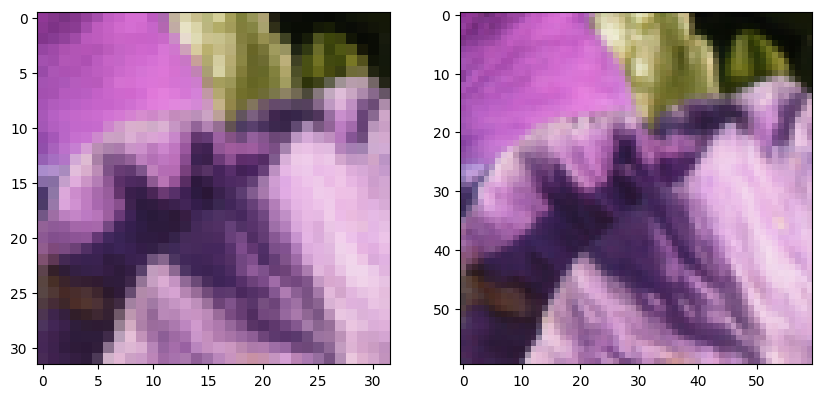

In [54]:
import matplotlib.pyplot as plt

# Display the first image in the batch
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(data[0].permute(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(label[0].permute(1, 2, 0))
plt.show()


In [56]:
# Define a function to convert PyTorch tensor to TensorFlow tensor
def torch_to_tf(tensor):
    return tf.convert_to_tensor(tensor.numpy())

num_epochs = 10000

for epoch in range(1, num_epochs+1):
    total_loss = 0
    total_accuracy = 0
    
    for data, label in train_loader:
        # Transpose data to match expected input shape (32, 32, 3)
        data = data.permute(0, 2, 3, 1)  # This will change the shape from (1, 3, 32, 32) to (1, 32, 32, 3)
        label = label.permute(0, 2, 3, 1)
        
        # Convert data and label to NumPy arrays and then to TensorFlow tensors
        data_tf = torch_to_tf(data)
        label_tf = torch_to_tf(label)
        
        # Train the model on the batch
        loss, accuracy = srcnn_model.train_on_batch(data_tf, label_tf)
        
        total_loss += loss
    
    # Print loss and accuracy every 10 epochs
    if epoch % 1000 == 0:
        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch}, Loss: {average_loss}")

Epoch 1000, Loss: 0.013104266128860988
Epoch 2000, Loss: 0.007948287726881413
Epoch 3000, Loss: 0.007171396989948475
Epoch 4000, Loss: 0.007298048299092513
Epoch 5000, Loss: 0.006651617514972503
Epoch 6000, Loss: 0.006279971092366255
Epoch 7000, Loss: 0.005897587344336968
Epoch 8000, Loss: 0.005839080263215762
Epoch 9000, Loss: 0.005859462723422509
Epoch 10000, Loss: 0.005581236301133266


In [ ]:
# print(len(train_loader.dataset))
# print(train_loader.dataset[0])

In [40]:
# # prompt: Train the model

# # Define loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(srcnn_model.parameters(), lr=0.001)

# # Training loop
# epochs = 200
# for epoch in range(epochs):
#   for i, (data, label) in enumerate(train_loader):
#     # Move data to device
#     data = data.to(device)
#     label = label.to(device)

#     # Forward pass
#     output = srcnn_model(data)

#     # Calculate loss
#     h, w = output.shape[2], output.shape[3]
#     # print(h, w)
#     transform_resize = transforms.Resize((h, w))
#     changed_label = transform_resize(label)
#     loss = criterion(output, changed_label)

#     # Backpropagation
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # Print training progress
#     if (epoch%100 == 0):
#       print(f"Epoch: {epoch + 1}/{epochs}, Batch: {i + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")

# # Save the trained model
# torch.save(model.state_dict(), "trained_model.pth")


# testing

In [98]:
# model = model.eval()

In [ ]:
# !wget -O butterfly.png https://raw.githubusercontent.com/JingyunLiang/SwinIR/main/testsets/RealSRSet%2B5images/butterfly.png

In [ ]:
# test_data, test_label = next(iter(train_loader))

In [ ]:
# test_img = test_data
# plt.figure(figsize=(3,3))
# plt.imshow(test_img[0].permute(1, 2, 0))
# plt.show()

In [ ]:
# img_lq = test_img[0].permute(1, 2, 0).clamp(0,1).numpy().astype(np.float32)
# img_lq = np.transpose(img_lq if img_lq.shape[2] == 1 else img_lq[:, :, [2, 1, 0]], (2, 0, 1))  # HCW-BGR to CHW-RGB
# img_lq = torch.from_numpy(img_lq).float().unsqueeze(0).to("cuda") # add .to() if u have cuda

# img_lq = test_img

In [ ]:

# print(img_lq.shape)

In [ ]:
# window_size = 8
# SCALE = 2
# with torch.no_grad():
#   # pad input image to be a multiple of window_size
#   _, _, h_old, w_old = img_lq.size()
#   h_pad = (h_old // window_size + 1) * window_size - h_old
#   w_pad = (w_old // window_size + 1) * window_size - w_old
#   img_lq = torch.cat([img_lq, torch.flip(img_lq, [2])], 2)[:, :, :h_old + h_pad, :]
#   img_lq = torch.cat([img_lq, torch.flip(img_lq, [3])], 3)[:, :, :, :w_old + w_pad]
#   print(img_lq.shape)
#   output = model(img_lq.to(device))
#   output = output[..., :h_old * SCALE, :w_old * SCALE]

# with torch.no_grad():
#   output = model(img_lq.to(device))


In [ ]:
# output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
# output = (output * 255.0).round().astype(np.uint8)

In [ ]:
# plt.imshow(output.transpose(1,2,0))
# plt.show()

1/1 [==============================] - 0s 80ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


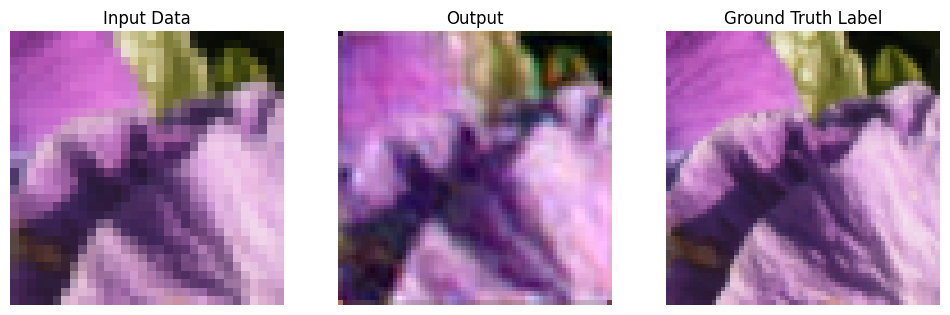

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


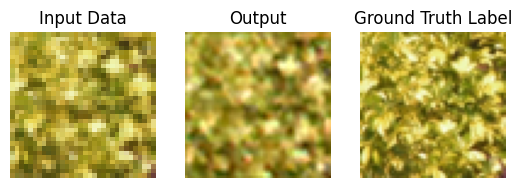

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


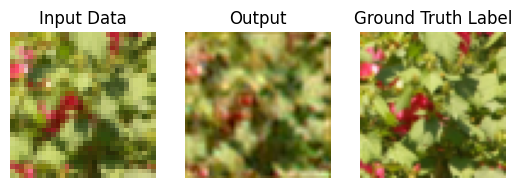

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


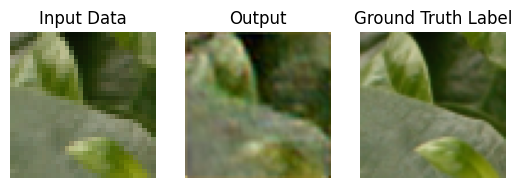

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


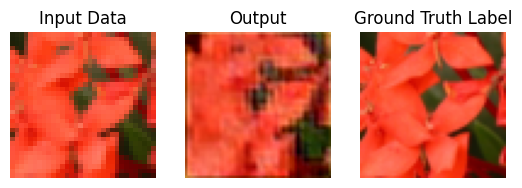

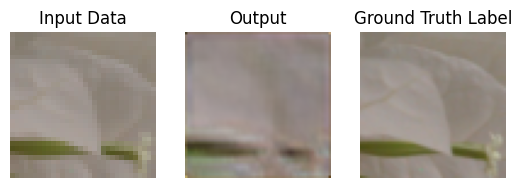

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


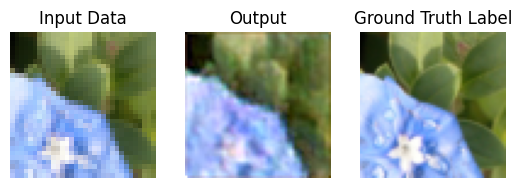

In [57]:
data, label = next(iter(train_loader))
data = data.permute(0, 2, 3, 1)  # This will change the shape from (1, 3, 32, 32) to (1, 32, 32, 3)
label = label.permute(0, 2, 3, 1)

# Convert data and label to NumPy arrays and then to TensorFlow tensors
data_tf = torch_to_tf(data)
label_tf = torch_to_tf(label)

output = srcnn_model.predict(data_tf)
# output = np.clip(output, 0, 1)*255

# Display the input data, output, and label
plt.figure(figsize=(12, 4))

for i in range(7):
    plt.subplot(1, 3, 1)
    plt.imshow(data[i])
    plt.title('Input Data')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(output[i])
    plt.title('Output')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(label[i])
    plt.title('Ground Truth Label')
    plt.axis('off')

    plt.show()

In [58]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import os

# Replace 'path/to/your/dataset' with the actual path
def makeTestLoader():
  dataset_root = '/home2/roja26/CV_PROJ/SWIN/trainsets/Set5'

  # Define transformations for your images (e.g., resize, normalize)
  transform_L = transforms.Compose([
      transforms.Resize((32,32)),  # Resize images to 256x256 (adjust as needed)
      transforms.ToTensor(),  # Convert images to tensors
      # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
  ])

  transform_H = transforms.Compose([
      transforms.Resize((60,60)),  # Resize images to 256x256 (adjust as needed)
      transforms.ToTensor(),  # Convert images to tensors
      # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
  ])

  # Create separate ImageFolder instances for data and label folders
  data_path = os.path.join(dataset_root, "X")
  label_path = os.path.join(dataset_root, "y")

  data_dataset = ImageFolder(root=data_path, transform=transform_L)
  label_dataset = ImageFolder(root=label_path, transform=transform_H)

  combined_dataset = []

  for i in range(0, len(data_dataset)):
      combined_dataset.append((data_dataset[i][0], label_dataset[i][0]))

  data_loader = DataLoader(data_dataset, batch_size=1, shuffle=False)
  label_loader = DataLoader(label_dataset, batch_size=1, shuffle=False)

  test_loader = DataLoader(combined_dataset, batch_size=5, shuffle=False)
  return test_loader


In [59]:
test_loader = makeTestLoader()

1/1 [==============================] - 0s 29ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


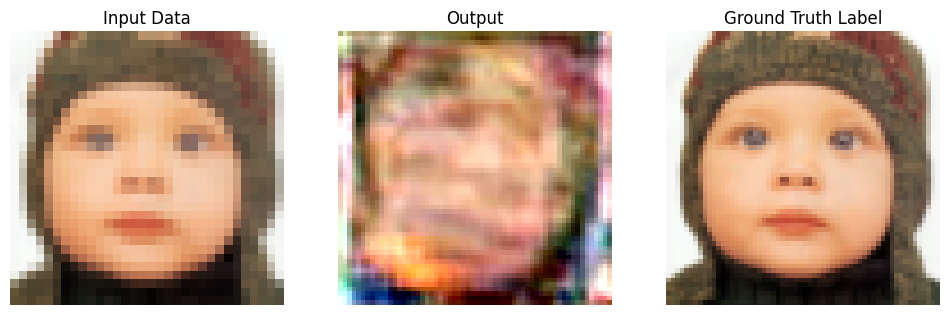

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


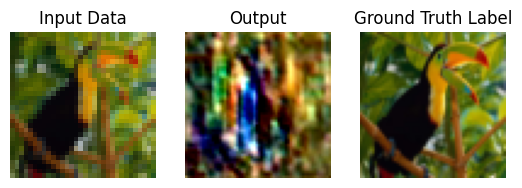

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


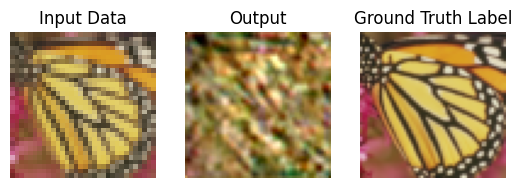

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


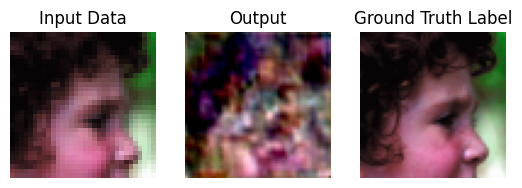

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


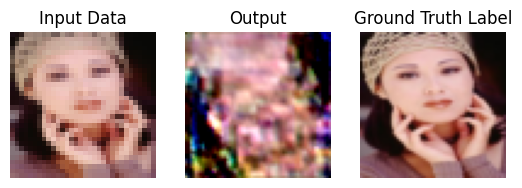

In [60]:
for img, label in test_loader:
  img = img.permute(0, 2, 3, 1)
  label = label.permute(0, 2, 3, 1)
  
  img_tf =torch_to_tf(img)
  label_tf = torch_to_tf(label)

  output = srcnn_model.predict(img_tf)

  # Display the input data, output, and label
  plt.figure(figsize=(12, 4))

  for i in range(5):
    plt.subplot(1, 3, 1)
    plt.imshow(img[i])
    plt.title('Input Data')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(output[i])
    plt.title('Output')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(label[i])
    plt.title('Ground Truth Label')
    plt.axis('off')

    plt.show()



